# Synthetic paleomagnetic APWPs inverted using `bayesian_pep` approach

The code is a PyMC3 implementation of the paleomagnetic Euler pole inversion method first developed in PyMC2 within Ian Rose's mcplates package: https://github.com/ian-r-rose/mcplates

The functions are within the `bayesian_pep` library which is imported below.

In [1]:
from bayesian_pep import *
# theano.config.floatX = 'float64'
import seaborn as sns

d2r = np.pi/180
r2d = 180/np.pi
eps = 1.e-6
%config InlineBackend.figure_format = 'retina'

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## One Euler pole inversion with minimal age uncertainty

### generate synthetic poles

In [2]:
start_age = 100
end_age = 0
number_of_poles = 5
euler_pole = [0,0]
euler_rate = 1
pole_a95 = 4
start_pole = [24, 19]

one_euler_data = generate_APWP_poles(number_of_poles, start_pole, start_age, end_age, euler_pole, euler_rate, pole_a95)
one_euler_data

,pole_lon,pole_lat,pole_age,pole_a95
0,24.000000,19.000000,100.0,4.0
1,13.724333,27.231977,75.0,4.0
2,359.854182,30.256654,50.0,4.0
3,346.026499,27.112309,25.0,4.0
4,335.843743,18.796033,0.0,4.0


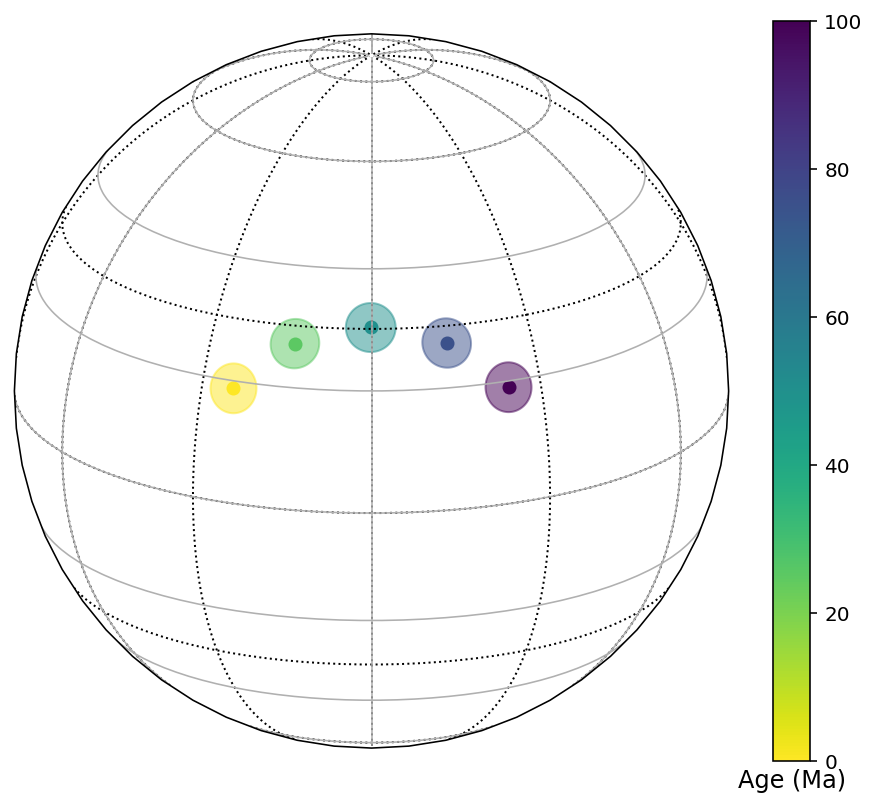

In [3]:
plot_paleomagnetic_poles(one_euler_data, central_latitude=20, add_land=0);

### invert for the Euler poles and Euler rates

In [4]:
with pm.Model() as model:
    
    #set the Euler pole position prior to be a uniform distribution (i.e. a Watson girdle with a very low k)
    euler_1 = Watson_Girdle('euler_1', lon_lat = [1.,1.,], k = -0.1, testval = np.array([1., 1.]), shape = 2)
    #set the Euler pole rate prior to be a uniform distribution between 0 and 4
    rate_1 = pm.Uniform('rate_1', 0, 4) 
    
    #set the the start age to be a tight normal distribution about the oldest pole age
    start_age = pm.Normal('start_pole_age', mu=one_euler_data['pole_age'].max(), sigma=0.01)
    print('starting pole age is: ', str(one_euler_data['pole_age'].max()))
    
    #set the start point of the path to be associated with the oldest paleomagnetic pole
    start_index = one_euler_data['pole_age'].argmax()
    start_lon_lat = [one_euler_data['pole_lon'].tolist()[start_index], one_euler_data['pole_lat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(one_euler_data['pole_a95'].tolist()[start_index])
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array([1., 1.]), shape = 2)
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    #create the Fisher distributions associated with the observed pole positions 
    for j in range(one_euler_data.shape[0]-1):
        i = j + 1
        age = pm.Normal('t'+str(i), mu=one_euler_data['pole_age'][i], sigma=0.01)
        print('pole '+str(i)+' age: ',one_euler_data['pole_age'][i])
        
        lon_lat = pole_position_1e(start, euler_1, rate_1, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(one_euler_data['pole_a95'].tolist()[i]), 
                            observed=[one_euler_data['pole_lon'].tolist()[i], one_euler_data['pole_lat'].tolist()[i]])
        
    #uncomment to run the model
    #trace_1e = pm.sample(100000, step = pm.Metropolis(), chains=1, init='auto')

starting pole age is:  100.0
starting pole lon/lat: [24.0, 19.0] starting pole k:  1225.0
pole 1 age:  75.0
pole 2 age:  50.0
pole 3 age:  25.0
pole 4 age:  0.0


In [5]:
# pm.save_trace(trace_1e, 'code_output/1_euler_trace', overwrite=1)

In [6]:
trace_1e_saved = pm.load_trace('code_output/1_euler_trace',model)

In [7]:
# axes = pm.traceplot(trace_1e_saved, compact=1)
# plt.subplots_adjust(hspace = 1)
# plt.savefig('code_output/1_euler_inversion_traceplot.pdf', bbox_inches='tight')

0.9611758891239083 0.7036047937759307 1.2325747400942728


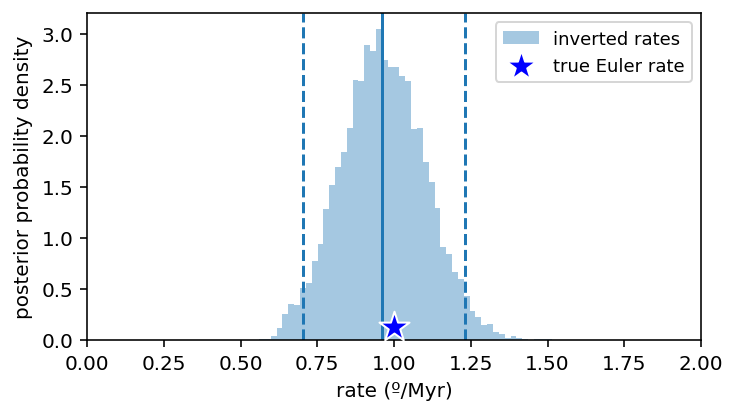

In [19]:
HPD_max = np.percentile(trace_1e_saved['rate_1'],97.5)
HPD_min = np.percentile(trace_1e_saved['rate_1'],2.5)
median = np.median(trace_1e_saved['rate_1'])
print(median, HPD_min, HPD_max)

plt.figure(figsize=(5.5,3))
sns.distplot(trace_1e_saved['rate_1'],kde=False, norm_hist=1, label = 'inverted rates')
plt.axvline(x=median)
plt.axvline(x=HPD_min,linestyle='--')
plt.axvline(x=HPD_max,linestyle='--')
plt.xlabel('rate (º/Myr)')
plt.ylabel('posterior probability density')
plt.xlim(0,2)
plt.scatter(euler_rate, plt.gca().get_ylim()[1]*0.04, marker = '*', s=250, 
            color = 'blue', edgecolor='white', label='true Euler rate', zorder=100)
plt.legend(prop={'size': 9})
plt.savefig('code_output/1_Euler_inversion_rate.png',dpi=600,bbox_inches='tight')

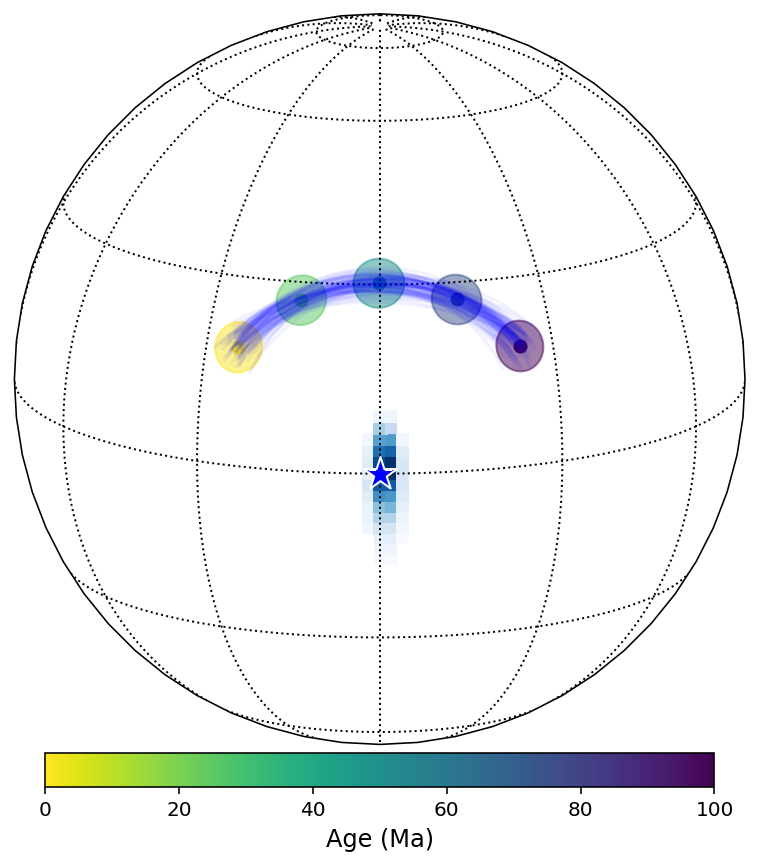

In [9]:
one_euler_ax = plot_trace_1e(trace_1e_saved, one_euler_data[['pole_lon', 'pole_lat']].to_numpy(), one_euler_data['pole_a95'], one_euler_data['pole_age'].tolist(), 
              central_lon=0, central_lat=15, num_paths_to_plot=100, cmap='Blues',
              savefig = 0, figname = 'code_output/1_Euler_inversion.png');
ipmag.plot_vgp(one_euler_ax, 0, 0, marker = '*', markersize = 300, color = 'blue', edge = 'white')
plt.savefig('code_output/1_Euler_inversion.png', dpi=600, bbox_inches='tight')

## One Euler pole inversion with A95 and age uncertainty

### generate synthetic poles with noise

In [4]:
start_age = 100
end_age = 0
number_of_poles = 5
euler_pole = [0,0]
euler_rate = 1
# generate A95 values with random noise following a normal distribution of N(mean=4, std=2)
pole_a95_noise = np.random.uniform(3,8, 5)
start_pole = [24, 19]

one_euler_data_noise = generate_APWP_poles(number_of_poles, start_pole, start_age, end_age, euler_pole, euler_rate, pole_a95_noise)
resampled_poles = np.array([ipmag.fishrot(k=kappa_from_two_sigma(A95), n=1, dec=dec, inc=inc, di_block=0)
                            for A95, dec, inc in zip(pole_a95_noise, one_euler_data_noise['pole_lon'], one_euler_data_noise['pole_lat'])]).T[0]
one_euler_data_noise['pole_lon_noise'] = resampled_poles[0]
one_euler_data_noise['pole_lat_noise'] = resampled_poles[1]
one_euler_data_noise['pole_a95'] = pole_a95_noise
one_euler_data_noise['pole_age_sigma'] = 5
one_euler_data_noise['pole_age_noise'] = [np.random.normal(i,5) for i in one_euler_data_noise['pole_age']]
one_euler_data_noise

,pole_lon,pole_lat,pole_age,pole_a95,pole_lon_noise,pole_lat_noise,pole_age_sigma,pole_age_noise
0,24,19,100.0,7.003346,24.242450,21.059912,5,95.752383
1,13.724333,27.231977,75.0,5.905214,13.078544,24.731072,5,76.103767
2,359.854182,30.256654,50.0,7.778837,358.190379,30.828171,5,50.064527
3,346.026499,27.112309,25.0,5.671265,352.269012,27.861758,5,22.110813
4,335.843743,18.796033,0.0,7.314027,339.684931,17.821997,5,1.953957


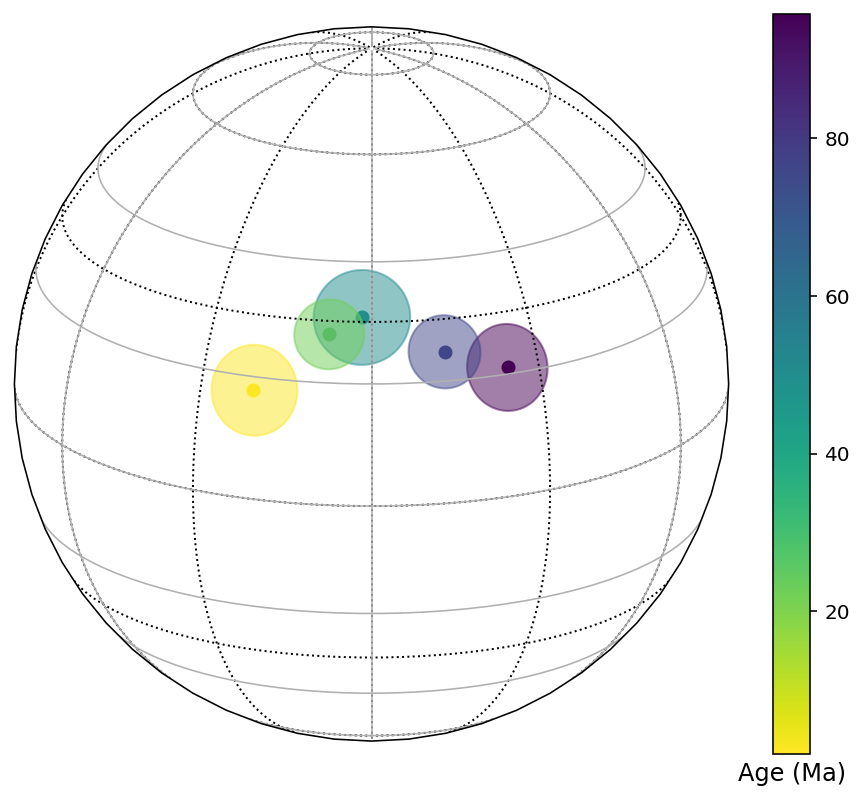

In [5]:
plot_paleomagnetic_poles(one_euler_data_noise, 
                         pole_lon='pole_lon_noise',
                        pole_lat='pole_lat_noise',
                        pole_a95='pole_a95',
                        pole_age='pole_age_noise', 
                         central_latitude=20, add_land=0);

### invert for the Euler poles and Euler rates

In [13]:
with pm.Model() as model:
    
    #set the Euler pole position prior to be a uniform distribution (i.e. a Watson girdle with a very low k)
    euler_1 = Watson_Girdle('euler_1', lon_lat = [1.,1.,], k = -.1, testval = np.array([0., 0.]), shape = 2)
    #set the Euler pole rate prior to be a uniform distribution between 0 and 4
    rate_1 = pm.Uniform('rate_1', 0, 4) 
    
    #set the the start age to be a tight normal distribution about the oldest pole age
    start_age = pm.Normal('start_pole_age', mu=one_euler_data_noise['pole_age_noise'].max(), sigma=0.01)
    print('starting pole age is: ', str(one_euler_data_noise['pole_age_noise'].max()))
    
    #set the start point of the path to be associated with the oldest paleomagnetic pole
    start_index = one_euler_data_noise['pole_age_noise'].argmax()
    start_lon_lat = [one_euler_data_noise['pole_lon_noise'].tolist()[start_index], one_euler_data_noise['pole_lat_noise'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(one_euler_data_noise['pole_a95'].tolist()[start_index])
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array([1., 1.]), shape = 2)
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    #create the Fisher distributions associated with the observed pole positions 
    for i in range(one_euler_data_noise.shape[0]):
        age = pm.Normal('t'+str(i), mu=one_euler_data_noise['pole_age_noise'][i], sigma=one_euler_data_noise['pole_age_sigma'][i])
        print('t'+str(i),one_euler_data_noise['pole_age_noise'][i])
        
        lon_lat = pole_position_1e(start, euler_1, rate_1, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(one_euler_data_noise['pole_a95'].tolist()[i]), 
                            observed=[one_euler_data_noise['pole_lon'].tolist()[i], one_euler_data_noise['pole_lat'].tolist()[i]])
        
    #uncomment to run the model
    trace_1e_noise = pm.sample(50000, step = pm.Metropolis(), cores=12, chains=4, init='auto')

starting pole age is:  95.75238293215511
starting pole lon/lat: [24.242450031511908, 21.059911961056237] starting pole k:  399.6179077174011
t0 95.75238293215511
t1 76.10376694794834
t2 50.06452708770833
t3 22.11081332486132
t4 1.9539567152554111


Multiprocess sampling (4 chains in 12 jobs)
CompoundStep
>Metropolis: [t4]
>Metropolis: [t3]
>Metropolis: [t2]
>Metropolis: [t1]
>Metropolis: [t0]
>Metropolis: [start_pole]
>Metropolis: [start_pole_age]
>Metropolis: [rate_1]
>Metropolis: [euler_1]


Sampling 4 chains for 1_000 tune and 50_000 draw iterations (4_000 + 200_000 draws total) took 684 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [14]:
pm.save_trace(trace_1e_noise, 'code_output/1_euler_trace_noise', overwrite=1)

'code_output/1_euler_trace_noise'

In [15]:
trace_1e_noise_saved = pm.load_trace('code_output/1_euler_trace_noise',model)

0.8349095363404888 0.46157472911822517 1.3686931295855567


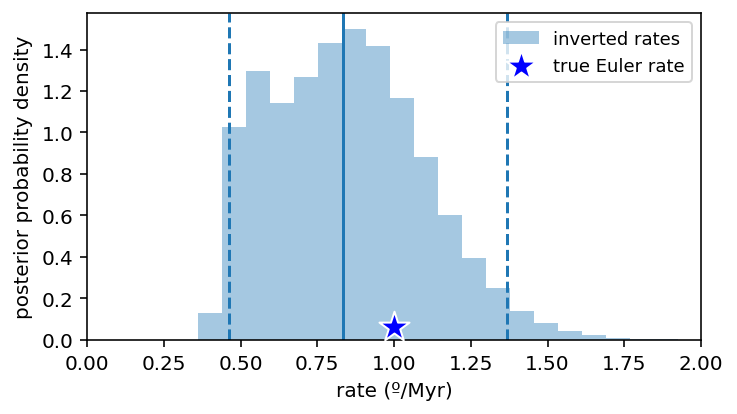

In [16]:
HPD_max = np.percentile(trace_1e_noise_saved['rate_1'],97.5)
HPD_min = np.percentile(trace_1e_noise_saved['rate_1'],2.5)
median = np.median(trace_1e_noise_saved['rate_1'])
print(median, HPD_min, HPD_max)

plt.figure(figsize=(5.5,3))
sns.distplot(trace_1e_noise_saved['rate_1'],kde=False, bins=20, norm_hist=1, label = 'inverted rates')
plt.axvline(x=median)
plt.axvline(x=HPD_min,linestyle='--')
plt.axvline(x=HPD_max,linestyle='--')
plt.xlabel('rate (º/Myr)')
plt.ylabel('posterior probability density')
plt.xlim(0,2)
plt.scatter(euler_rate, plt.gca().get_ylim()[1]*0.04, marker = '*', s=250, 
            color = 'blue', edgecolor='white', label='true Euler rate', zorder=100)
plt.legend(prop={'size': 9})
# plt.savefig('code_output/1_Euler_inversion_rate.png',dpi=600,bbox_inches='tight')

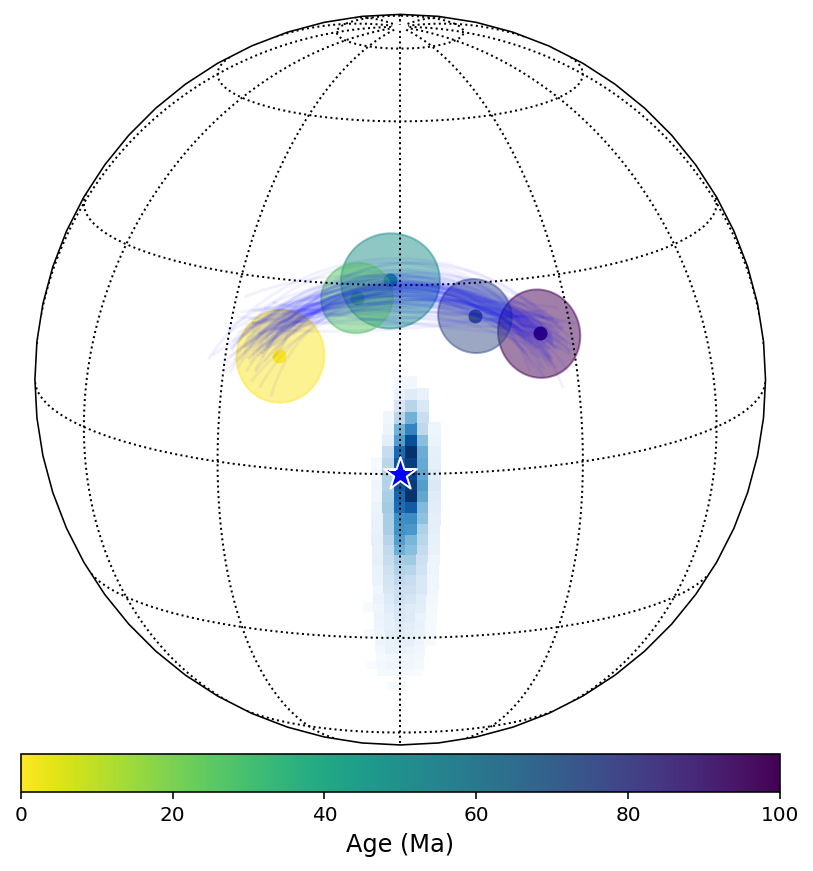

In [18]:
one_euler_ax, noise_1e_likelihood = plot_trace_1e(trace_1e_noise_saved, one_euler_data_noise[['pole_lon_noise', 'pole_lat_noise']].to_numpy(), one_euler_data_noise['pole_a95'], one_euler_data_noise['pole_age'].tolist(), 
              central_lon=0, central_lat=15, num_paths_to_plot=100, cmap='Blues',
              savefig = 0, figname = 'code_output/1_Euler_inversion.png');
ipmag.plot_vgp(one_euler_ax, 0, 0, marker = '*', markersize = 300, color = 'blue', edge = 'white')
# plt.savefig('code_output/1_Euler_inversion.png', dpi=600, bbox_inches='tight')

## Two Euler pole inversion

### generate synthetic poles

In [12]:
start_age_1 = 120
end_age_1 = 60
number_of_poles_1 = 5
euler_pole_1 = [0,-10]
euler_rate_1 = 1.5
pole_a95_1 = 4
start_pole_1 = [30, -5]

two_euler_data_1 = generate_APWP_poles(number_of_poles_1, start_pole_1, start_age_1, end_age_1, euler_pole_1, euler_rate_1, pole_a95_1)

start_age_2 = 60
end_age_2 = 0
number_of_poles_2 = 5
euler_pole_2 = [-60,10]
euler_rate_2 = .75
pole_a95_2 = 4
start_pole_2 = [two_euler_data_1['pole_lon'][4], two_euler_data_1['pole_lat'][4]]

two_euler_data_2 = generate_APWP_poles(number_of_poles_2, start_pole_2, start_age_2, end_age_2, euler_pole_2, euler_rate_2, pole_a95_2)
two_euler_data = pd.concat([two_euler_data_1,two_euler_data_2[1:]])
two_euler_data.reset_index(inplace=True)
two_euler_data

,index,pole_lon,pole_lat,pole_age,pole_a95
0,0,30.000000,-5.000000,120.0,4.0
1,1,25.957841,5.495399,105.0,4.0
2,2,18.439918,13.960144,90.0,4.0
3,3,7.999308,19.095230,75.0,4.0
4,4,356.098440,19.899208,60.0,4.0
5,1,355.203027,29.057709,45.0,4.0
6,2,352.832034,38.038463,30.0,4.0
7,3,348.362466,46.623101,15.0,4.0
8,4,340.690169,54.431584,0.0,4.0


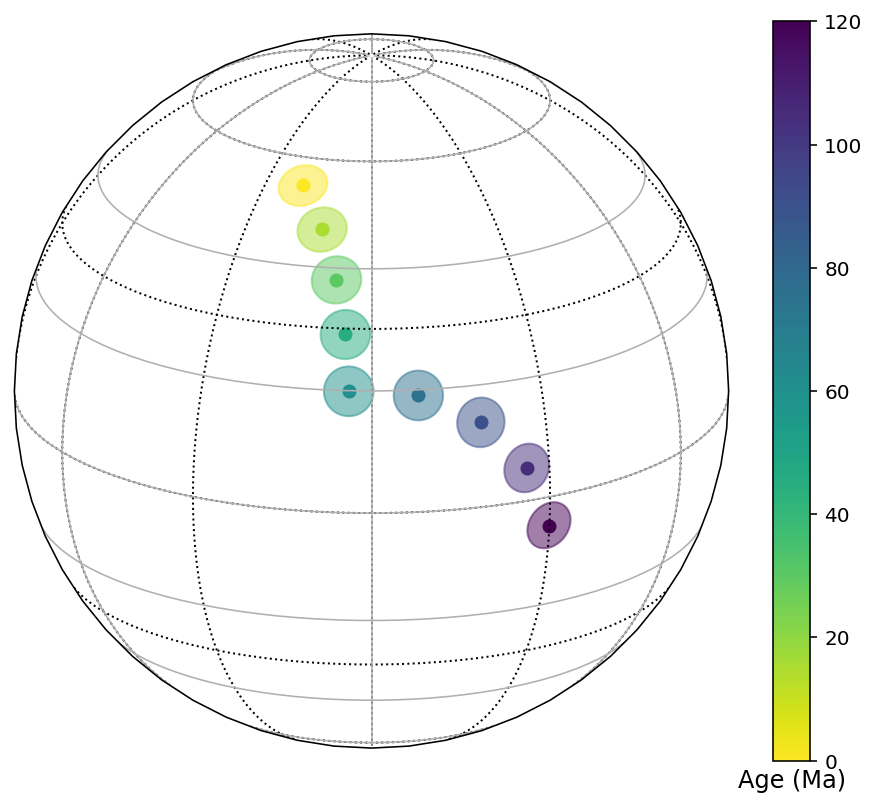

In [13]:
plot_paleomagnetic_poles(two_euler_data, central_latitude=20, add_land=0);

In [14]:
with pm.Model() as model:

    euler_1 = Watson_Girdle('euler_1', lon_lat = [1.,0.,], k = -0.1, testval = np.array([1., 0.]), shape = 2)
    rate_1 = pm.Uniform('rate_1', 0.0, 4.0)  
    euler_2 = Watson_Girdle('euler_2', lon_lat = [1.,0.,], k = -0.1, testval = np.array([1., 0.]), shape = 2)
    rate_2 = pm.Uniform('rate_2', 0.0, 4.0) 
    
    start_age = pm.Normal('start_pole_age', two_euler_data['pole_age'].max(), 0.01)
    print('starting pole age is: ', str(two_euler_data['pole_age'].max()))
    
    start_index = two_euler_data['pole_age'].argmax()
    
    start_lon_lat = [two_euler_data['pole_lon'].tolist()[start_index], two_euler_data['pole_lat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(two_euler_data['pole_a95'].tolist()[start_index])
    
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array(start_lon_lat), shape = 2)
    
    switchpoint = pm.Uniform('switchpoint', two_euler_data['pole_age'].min(), two_euler_data['pole_age'].max())

    for i in range(two_euler_data.shape[0]):
        
        age = pm.Normal('t'+str(i), mu=two_euler_data['pole_age'][i], sigma=0.01)
        print('pole '+str(i)+' age: ',two_euler_data['pole_age'][i])
        
        lon_lat = pole_position_2e(start, euler_1, rate_1, euler_2, rate_2, switchpoint, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(two_euler_data['pole_a95'].tolist()[i]), 
                            observed=[two_euler_data['pole_lon'].tolist()[i], two_euler_data['pole_lat'].tolist()[i]])
        
#     trace_2e = pm.sample(25000, step = pm.Metropolis(), compute_convergence_checks=1, chains=1, cores=1)

starting pole age is:  120.0
pole 0 age:  120.0
pole 1 age:  105.0
pole 2 age:  90.0
pole 3 age:  75.0
pole 4 age:  60.0
pole 5 age:  45.0
pole 6 age:  30.0
pole 7 age:  15.0
pole 8 age:  0.0


In [15]:
# pm.save_trace(trace_2e, 'code_output/2_euler_trace', overwrite=1)

In [16]:
trace_2e_saved = pm.load_trace('code_output/2_euler_trace',model)[5000:]

In [15]:
# plt.figure(figsize=(10, 20))
# axes = pm.traceplot(trace_2e_saved, compact=1)
# plt.subplots_adjust(hspace = 1 )
# plt.savefig('code_output/2_euler_inversion_traceplot.pdf', bbox_inches='tight')

In [16]:
def plot_trace_2e( trace, lon_lats, A95s, ages, central_lon = 30., central_lat = 30., num_paths_to_plot = 500, 
                  savefig = True, figname = '2_Euler_inversion_test.pdf', path_resolution=100, **kwargs):
    def pole_position( start, euler_1, rate_1, euler_2, rate_2, switchpoint, start_age, age ):

        euler_pole_1 = EulerPole( euler_1[0], euler_1[1], rate_1)
        euler_pole_2 = EulerPole( euler_2[0], euler_2[1], rate_2)
        start_pole = PaleomagneticPole(start[0], start[1], age=start_age)

        if age > switchpoint:
            start_pole.rotate( euler_pole_1, euler_pole_1.rate*(start_age-age))
        else:
            start_pole.rotate( euler_pole_1, euler_pole_1.rate*(start_age-switchpoint))
            start_pole.rotate( euler_pole_2, euler_pole_2.rate*(switchpoint-age))

        lon_lat = np.ndarray.flatten(np.array([start_pole.longitude, start_pole.latitude]))

        return lon_lat
    
    euler_1_directions = trace.euler_1
    rates_1 = trace.rate_1

    euler_2_directions = trace.euler_2
    rates_2 = trace.rate_2

    start_directions = trace.start_pole
    start_ages = trace.start_pole_age
    switchpoints = trace.switchpoint
    
    interval = max([1,int(len(rates_1)/num_paths_to_plot)])

    #ax = plt.axes(projection = ccrs.Orthographic(0.,30.))
    ax = ipmag.make_orthographic_map(central_lon, central_lat, add_land=0, grid_lines = 1)
    
    plot_distributions(ax, euler_1_directions[:,0], euler_1_directions[:,1], cmap = 'Blues', **kwargs)
    plot_distributions(ax, euler_2_directions[:,0], euler_2_directions[:,1], cmap = 'Reds', **kwargs)
    
    age_list = np.linspace(min(ages), max(ages), path_resolution)
    pathlons = np.empty_like(age_list)
    pathlats = np.empty_like(age_list)
    
    for start, e1, r1, e2, r2, switch, start_age \
                 in zip(start_directions[::interval], 
                        euler_1_directions[::interval], rates_1[::interval],
                        euler_2_directions[::interval], rates_2[::interval],
                        switchpoints[::interval], start_ages[::interval]):
        for i,a in enumerate(age_list):
            lon_lat = pole_position( start, e1, r1, e2, r2, switch, start_age, a)
            pathlons[i] = lon_lat[0]
            pathlats[i] = lon_lat[1]
        
        old_lons = [pathlons[i] if age_list[i] > switch else None for i in range(len(age_list))]
        old_lats = [pathlats[i] if age_list[i] > switch else None for i in range(len(age_list))]
        young_lons = [pathlons[i] if age_list[i] <= switch else None for i in range(len(age_list))]
        young_lats = [pathlats[i] if age_list[i] <= switch else None for i in range(len(age_list))]
        
        ax.plot(young_lons,young_lats,color='r', transform=ccrs.Geodetic(), alpha=0.05)
        ax.plot(old_lons,old_lats,color='b', transform=ccrs.Geodetic(), alpha=0.05)
        
    # plot paleomagnetic observation poles here
    cNorm  = matplotlib.colors.Normalize(vmin=min(ages), vmax=max(ages))
    scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')

    pole_colors = [colors.rgb2hex(scalarMap.to_rgba(ages[i])) for i in range(len(ages))]
        
    cbar = plt.colorbar(scalarMap, shrink=0.75, location='bottom', pad=0.01)
    cbar.ax.set_xlabel('Age (Ma)', fontsize=12) 
    for i in range(len(lon_lats)):
        this_pole = Pole(lon_lats[i][0], lon_lats[i][1], A95=A95s[i])
        this_pole.plot(ax, color=pole_colors[i])
    if savefig == True:
        plt.savefig(figname,dpi=600,bbox_inches='tight')
    return ax

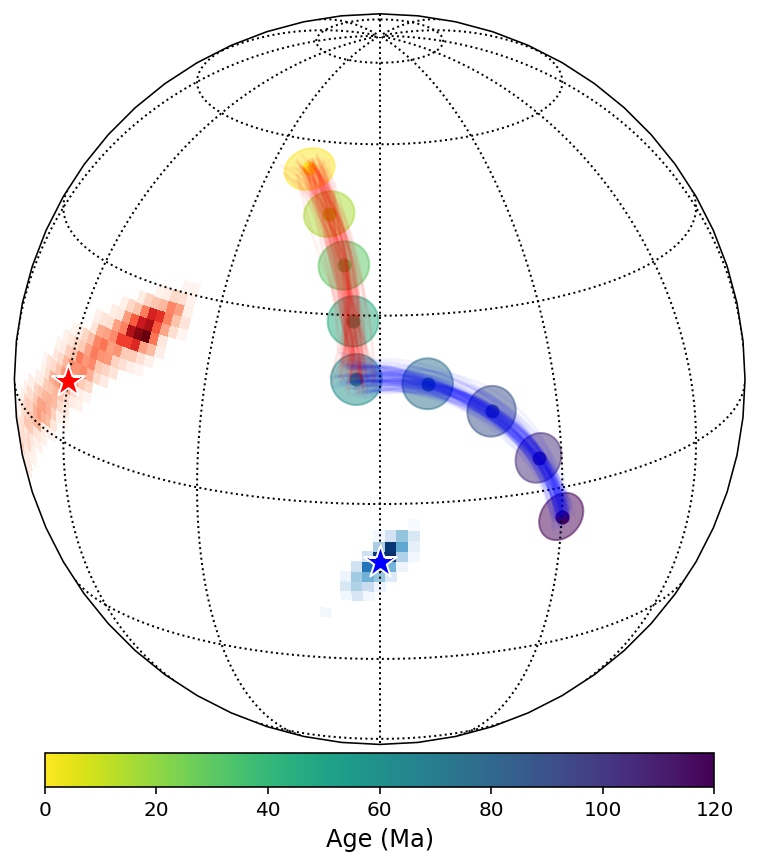

In [17]:
two_euler_ax = plot_trace_2e(trace_2e_saved, two_euler_data[['pole_lon', 'pole_lat']].to_numpy(), two_euler_data['pole_a95'], two_euler_data['pole_age'].tolist(), 
              0, 20, 100, savefig=0, figname='code_output/2_Euler_inversion.png')
ipmag.plot_vgp(two_euler_ax, 0,-10, marker='*', color = 'blue', edge = 'white',markersize=300)
ipmag.plot_vgp(two_euler_ax, -60,10, marker='*', color = 'red', edge='white',markersize=300)
plt.savefig('code_output/2_Euler_inversion.png', dpi=600, bbox_inches='tight')

1.4545616185911183 1.0718225776103885 1.7985923513156217
0.7620591143571274 0.570397947776368 1.2404647576082488


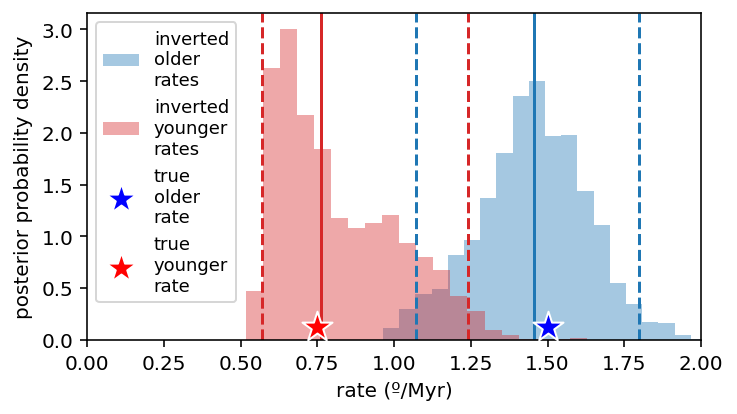

In [18]:
HPD_max_1 = np.percentile(trace_2e_saved['rate_1'],97.5)
HPD_min_1 = np.percentile(trace_2e_saved['rate_1'],2.5)
median_1 = np.median(trace_2e_saved['rate_1'])
print(median_1, HPD_min_1, HPD_max_1)

HPD_max_2 = np.percentile(trace_2e_saved['rate_2'],97.5)
HPD_min_2 = np.percentile(trace_2e_saved['rate_2'],2.5)
median_2 = np.median(trace_2e_saved['rate_2'])
print(median_2, HPD_min_2, HPD_max_2)

plt.figure(figsize=(5.5,3))
sns.distplot(trace_2e_saved['rate_1'],kde=False, norm_hist=1, bins=20,label = 'inverted\nolder\nrates')
sns.distplot(trace_2e_saved['rate_2'],kde=False, norm_hist=1, bins=20, color = 'C3',label = 'inverted\nyounger\nrates')

plt.axvline(x=median_1)
plt.axvline(x=HPD_min_1,linestyle='--')
plt.axvline(x=HPD_max_1,linestyle='--')

plt.axvline(x=median_2, color = 'C3')
plt.axvline(x=HPD_min_2,linestyle='--', color = 'C3')
plt.axvline(x=HPD_max_2,linestyle='--', color = 'C3')

plt.xlabel('rate (º/Myr)')
plt.ylabel('posterior probability density')
plt.xlim(0,2)

plt.scatter(euler_rate_1, plt.gca().get_ylim()[1]*0.04, marker = '*', s=250, 
            color = 'b', edgecolor='white', label='true\nolder\nrate', zorder=100)
plt.scatter(euler_rate_2, plt.gca().get_ylim()[1]*0.04, marker = '*', s=250, 
            color = 'r', edgecolor='white', label='true\nyounger\nrate', zorder=100)

plt.legend(loc='upper left',prop={'size': 9})
plt.savefig('code_output/2_Euler_inversion_rate.png',dpi=600,bbox_inches='tight')

## Generate figure of synthetic 1 and 2 Euler inversions

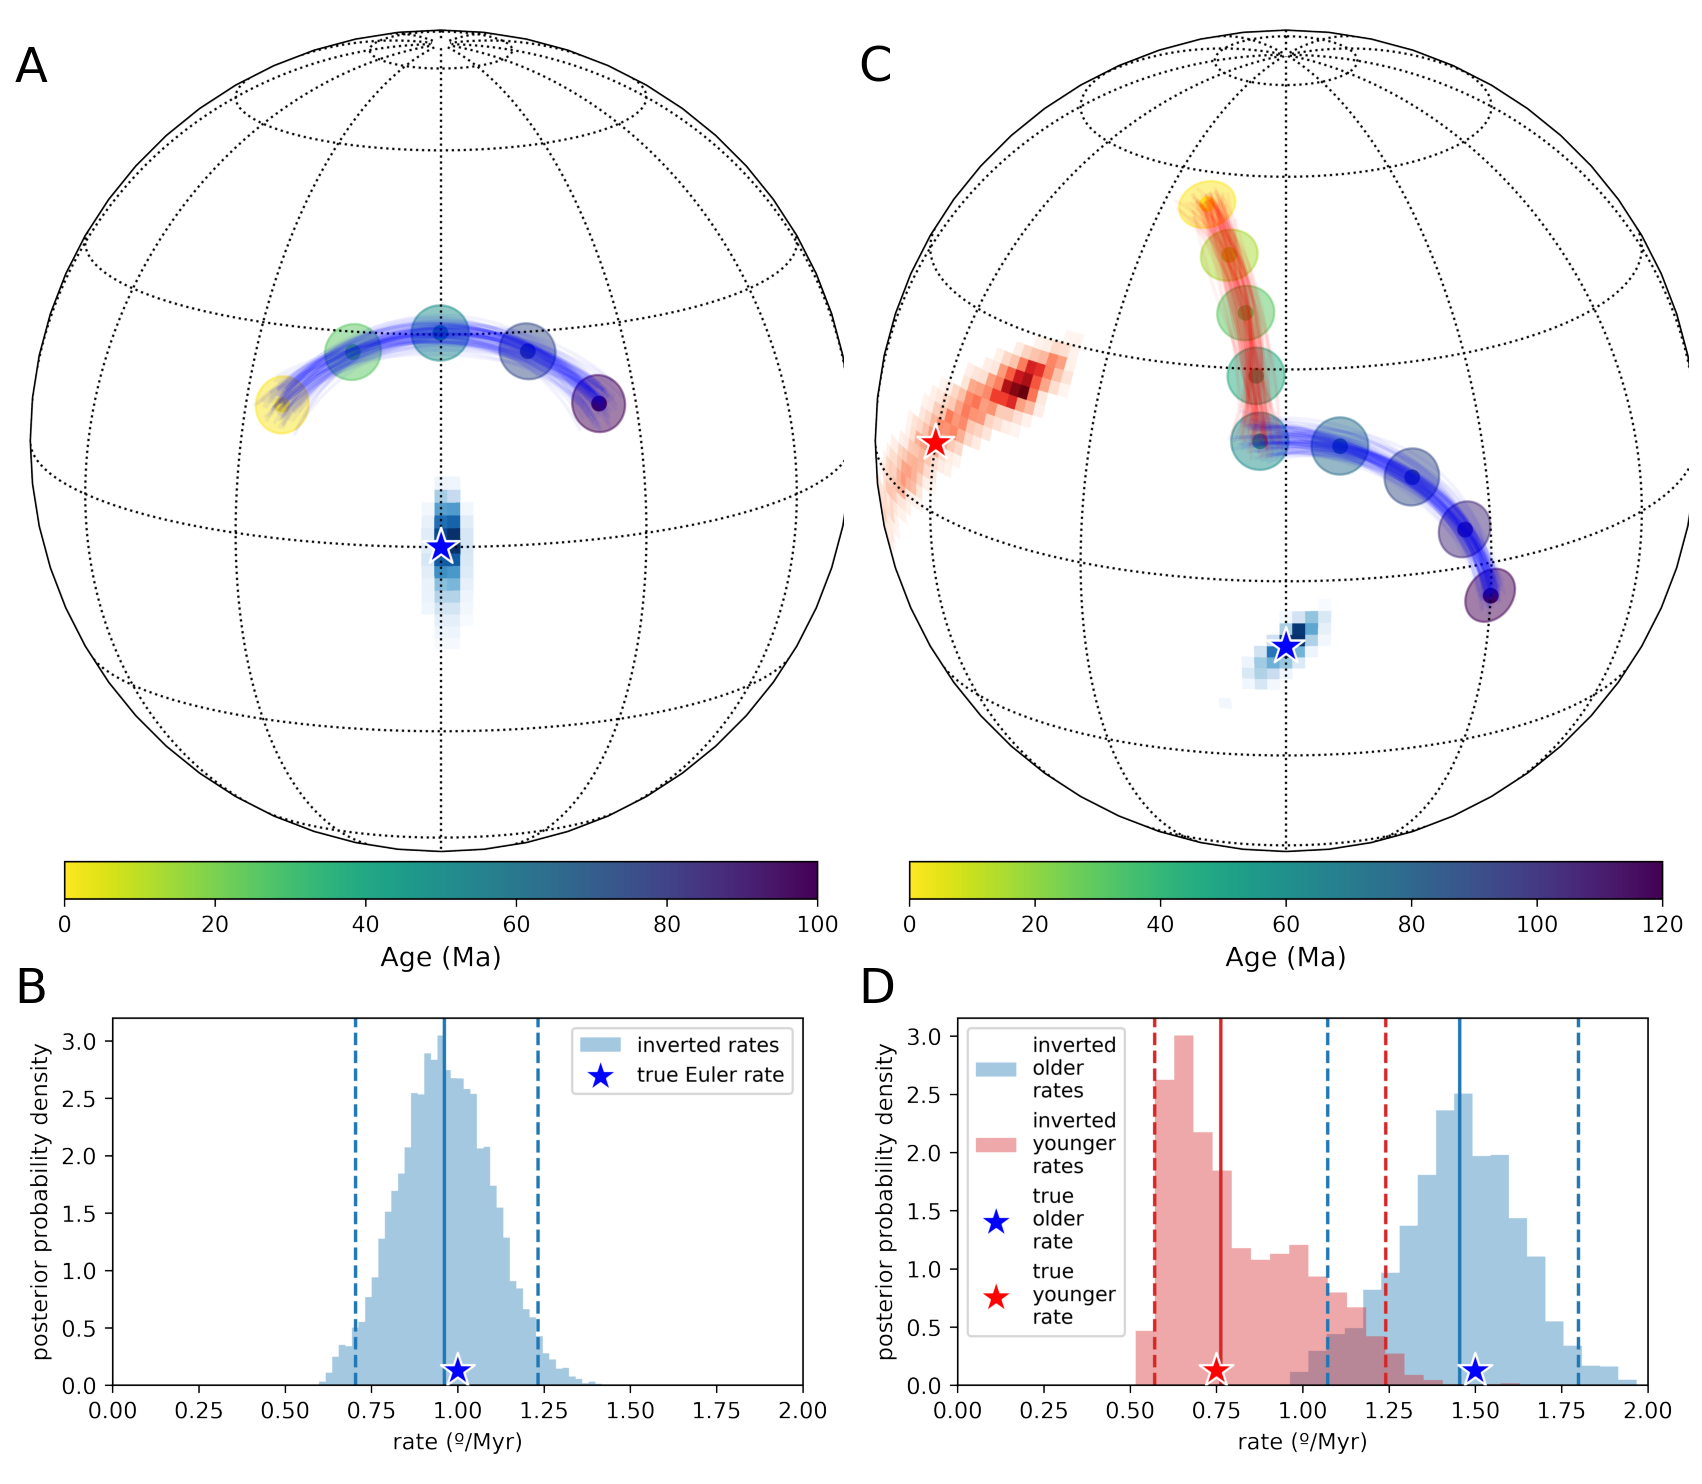

In [20]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.image as mpimg

one_euler_map_img = mpimg.imread('code_output/1_Euler_inversion.png')
one_euler_rate_img = mpimg.imread('code_output/1_Euler_inversion_rate.png')

two_euler_map_img = mpimg.imread('code_output/2_Euler_inversion.png')
two_euler_rate_img = mpimg.imread('code_output/2_Euler_inversion_rate.png')


fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
i = 0
for ax, im in zip(grid, [one_euler_map_img,
                         two_euler_map_img,
                         one_euler_rate_img,
                         two_euler_rate_img]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.axis("off")
    
    if i == 0:
        ax.text(0,250,"A",fontsize=24)
    if i == 1:
        ax.text(0,250,"C",fontsize=24)    
    if i == 2:
        ax.text(0,0,"B",fontsize=24)
    if i == 3:
        ax.text(0,0,"D",fontsize=24)
    i = i + 1
        

plt.subplots_adjust(wspace=0.2, hspace=0)

#fig.text(0,1,"A", color ="k",fontsize='large')

plt.savefig('./code_output/fig_synthetic_pep.png',dpi=600,bbox_inches='tight')
plt.show()

## One Euler pole inversion with various age constraints

### generate synthetic poles

In [20]:
start_age = 140
end_age = 40
number_of_poles = 5
euler_pole = [0,0]
euler_rate = 1
pole_a95 = 4
start_pole = [24, 19]

one_euler_age_data = generate_APWP_poles(number_of_poles, start_pole, start_age, end_age, euler_pole, euler_rate, pole_a95)
one_euler_age_data['pole_age'] = [140., None, None, None, 40.]
one_euler_age_data['age_sigma'] = [5., None, None, None, 5.]
one_euler_age_data

,pole_lon,pole_lat,pole_age,pole_a95,age_sigma
0,24.000000,19.000000,140.0,4.0,5.0
1,13.724333,27.231977,NaN,4.0,NaN
2,359.854182,30.256654,NaN,4.0,NaN
3,346.026499,27.112309,NaN,4.0,NaN
4,335.843743,18.796033,40.0,4.0,5.0


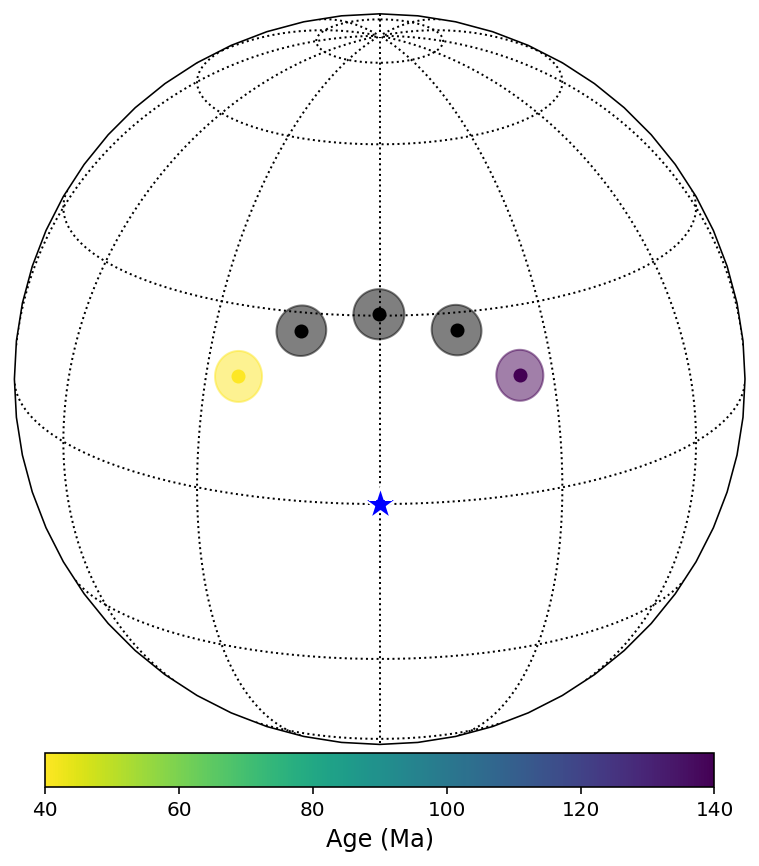

In [21]:
age_uncertainty_ax = plot_paleomagnetic_poles(one_euler_age_data, central_latitude=20, add_land=0)
ipmag.plot_vgp(age_uncertainty_ax, 0,0, marker='*', color = 'blue', edge='white',markersize=300)
plt.savefig('code_output/1_euler_prior_poles.png', dpi=600, bbox_inches='tight')

### generate pole age prior distributions

In [22]:
def get_age_boundaies(ages, age_sigmas):
    real_ages = []
    real_sigma = []
    for i in range(len(ages)):
        if np.isnan(age_sigmas[i]) == 0  :
            real_ages.append(ages[i])
            real_sigma.append(age_sigmas[i])
#     print(real_ages)      
    age_upper = max(real_ages)+3*age_sigmas[np.argmax(real_sigma)]
    age_lower = min(real_ages)-3*age_sigmas[np.argmin(real_sigma)]
    return max(real_ages), min(real_ages), age_upper, age_lower

def plot_age_prior(ages, age_sigmas, **kwargs):

    age_max, age_min, age_upper, age_lower = get_age_boundaies(ages, age_sigmas)
    
    print(age_upper, age_lower)
    fig, ax = plt.subplots(figsize=(6, 3))

    cNorm  = matplotlib.colors.Normalize(vmin=age_min, vmax=age_max)
    scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')

    color_list = [colors.rgb2hex(scalarMap.to_rgba(ages[i])) for i in range(len(ages))]

#     cbar = plt.colorbar(scalarMap, shrink=0.85)
#     cbar.ax.set_xlabel('Age (Ma)', fontsize=12)                               
    max_y = 0
                                       
    for i in range(len(ages)):
        this_age = ages[i]
        this_age_sigma = age_sigmas[i]


        if np.isnan(this_age_sigma) == 1:
            # this means we do not know the age of the pole except it is between the min and max age of the list

            x = np.linspace(age_lower, age_upper, 500)
            y = np.zeros(500)
            y[(x< age_upper) & (x>age_lower)] = 1.0/(age_upper-age_lower)

            color_list[i] = 'grey'
            if max_y < max(y):
                max_y = max(y)
                                       
        else:
            mu = this_age
            sigma = this_age_sigma

            x = np.linspace(mu-3*sigma,mu+3*sigma, 1000)
            y = st.norm.pdf(x, mu, sigma)
            if max_y < max(y):
                max_y = max(y)
        ax.plot(x, y, color = color_list[i], lw=1)
        ax.fill_between(x, y, color = color_list[i], alpha = 0.2)
        
    ax.grid(ls='--')
    ax.set_xlim(age_lower*0.9, age_upper+age_lower*0.1)
    ax.set_ylim(0, max_y*1.1)
    ax.set_ylabel('Probability density')
    ax.set_xlabel('Age (Ma)')
#     ax.set_title('Prior distributions assigned to age of poles', fontdict={'fontsize':14})
    
    return ax

155.0 25.0


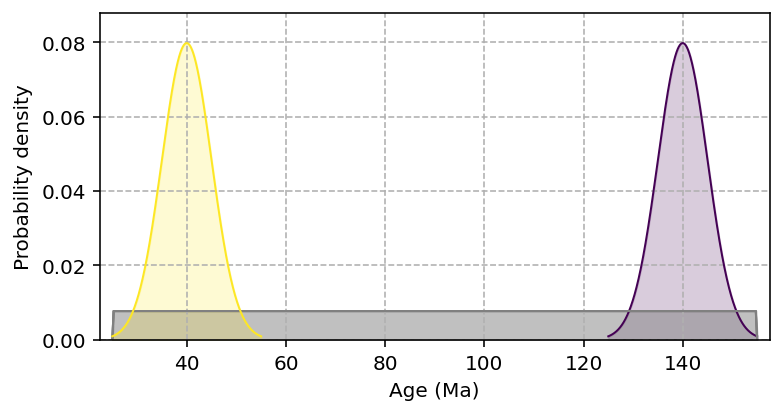

In [23]:
plot_age_prior(one_euler_age_data['pole_age'].tolist(), one_euler_age_data['age_sigma'].tolist())
plt.savefig('code_output/1_euler_prior_ages.png', dpi=600, bbox_inches='tight')

### invert for the Euler poles and Euler rates

In [24]:
with pm.Model() as model:
    
    _, _ , age_upper, age_lower = get_age_boundaies(one_euler_age_data['pole_age'].tolist(), one_euler_age_data['age_sigma'].tolist())
    print('upper age bound: ', age_upper, 'lower age bound: ', age_lower)
    
    euler_1 = Watson_Girdle('euler_1', lon_lat = [1.,1.,], k = -.1, testval = np.array([1., 1.]), shape = 2)
    rate_1 = pm.Uniform('rate_1', 0, 4) 
    
    start_age = pm.Normal('start_pole_age', one_euler_age_data['pole_age'].max(), 0.1)
    print('starting pole age is: ', str(one_euler_age_data['pole_age'].max()))
    
    start_index = one_euler_age_data['pole_age'].argmax()
    
    start_lon_lat = [one_euler_age_data['pole_lon'].tolist()[start_index], one_euler_age_data['pole_lat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(one_euler_age_data['pole_a95'].tolist()[start_index])
    
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array([1., 1.]), shape = 2)
    
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    
    for i in range(one_euler_age_data.shape[0]):
        if np.isnan(one_euler_age_data['age_sigma'][i]) == 1:
            # uniform
            age = pm.Uniform('t'+str(i), age_lower, age_upper)
            print('pole '+str(i)+' age: ', age_lower, '-', age_upper)
        else: 
            age = pm.Normal('t'+str(i), mu=one_euler_age_data['pole_age'][i], sigma=one_euler_age_data['age_sigma'][i])
            
            print('pole '+str(i)+' age: ',one_euler_age_data['pole_age'][i], u"\u00B1", one_euler_age_data['age_sigma'][i])
        
        lon_lat = pole_position_1e(start, euler_1, rate_1, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(one_euler_age_data['pole_a95'].tolist()[i]), 
                            observed=[one_euler_age_data['pole_lon'].tolist()[i], one_euler_age_data['pole_lat'].tolist()[i]])
        
#     trace_1e_age = pm.sample(10000, step = pm.Metropolis(), compute_convergence_checks=1, chains=1, cores=1, init='auto')

upper age bound:  155.0 lower age bound:  25.0
starting pole age is:  140.0
starting pole lon/lat: [24.0, 19.0] starting pole k:  1225.0
pole 0 age:  140.0 ± 5.0
pole 1 age:  25.0 - 155.0
pole 2 age:  25.0 - 155.0
pole 3 age:  25.0 - 155.0
pole 4 age:  40.0 ± 5.0


In [25]:
# pm.save_trace(trace_1e_age, 'code_output/1_euler_age_trace', overwrite=1)

In [21]:
trace_1e_age_saved = pm.load_trace('code_output/1_euler_age_trace',model)

In [27]:
# plt.figure(figsize=(10, 20))
# axes = pm.traceplot(trace_1e_age_saved, compact=1)
# plt.subplots_adjust(hspace = 1 )
# plt.savefig('code_output/1_euler_age_inversion_traceplot.pdf', bbox_inches='tight')

<GeoAxesSubplot:>

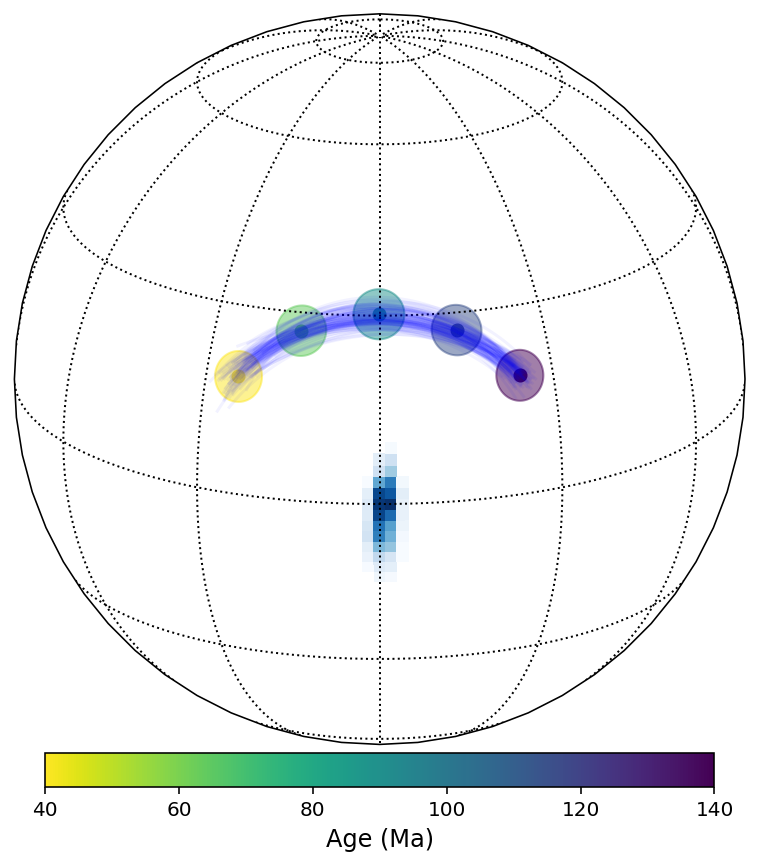

In [28]:
plot_trace_1e(trace_1e_age_saved, one_euler_age_data[['pole_lon', 'pole_lat']].to_numpy(), one_euler_age_data['pole_a95'], one_euler_age_data['pole_age'].tolist(), 
              0, 20, 100, savefig=1, figname='code_output/1_Euler_posterior_poles.png', estimate_pole_age=1, cmap='Blues')

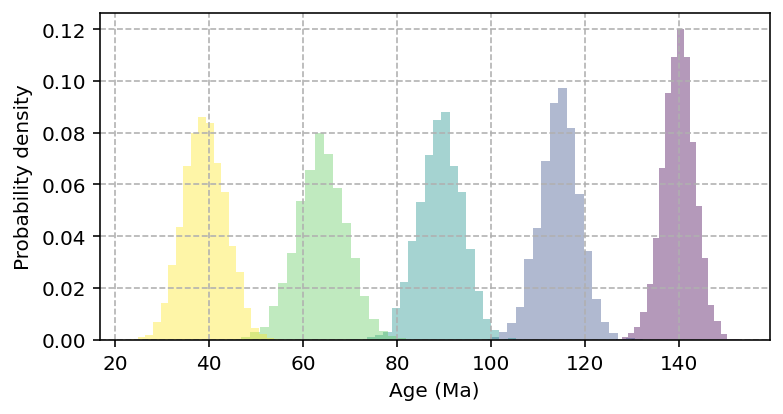

In [29]:
plt.figure(figsize=(6, 3))

cNorm  = matplotlib.colors.Normalize(vmin=min(one_euler_age_data['pole_age']), vmax=max(one_euler_age_data['pole_age']))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')

pole_colors = [colors.rgb2hex(scalarMap.to_rgba(np.median(trace_1e_age_saved['t'+str(i)]))) 
               for i in range(len(one_euler_age_data['pole_age']))]

pole_age_list = ['t0', 't1', 't2', 't3', 't4']
for i in range(len(pole_age_list)):
    sns.distplot(trace_1e_age_saved[pole_age_list[i]], kde=0, norm_hist=1,  bins=20,
              color = pole_colors[i])
plt.grid(ls='--')
# plt.hist(trace_1e_age_df['t0'])
# plt.distplot(data=trace_1e_age_df['t1'])
# plt.distplot(data=trace_1e_age_df['t2'])
# plt.distplot(data=trace_1e_age_df['t3'])
# plt.distplot(data=trace_1e_age_df['t4'])
plt.ylabel('Probability density')
plt.xlabel('Age (Ma)')
plt.savefig('code_output/1_euler_posterior_ages.png', dpi=600, bbox_inches='tight')
plt.show()

## Generate figure of synthetic 1 euler inversion with prior age uncertainties

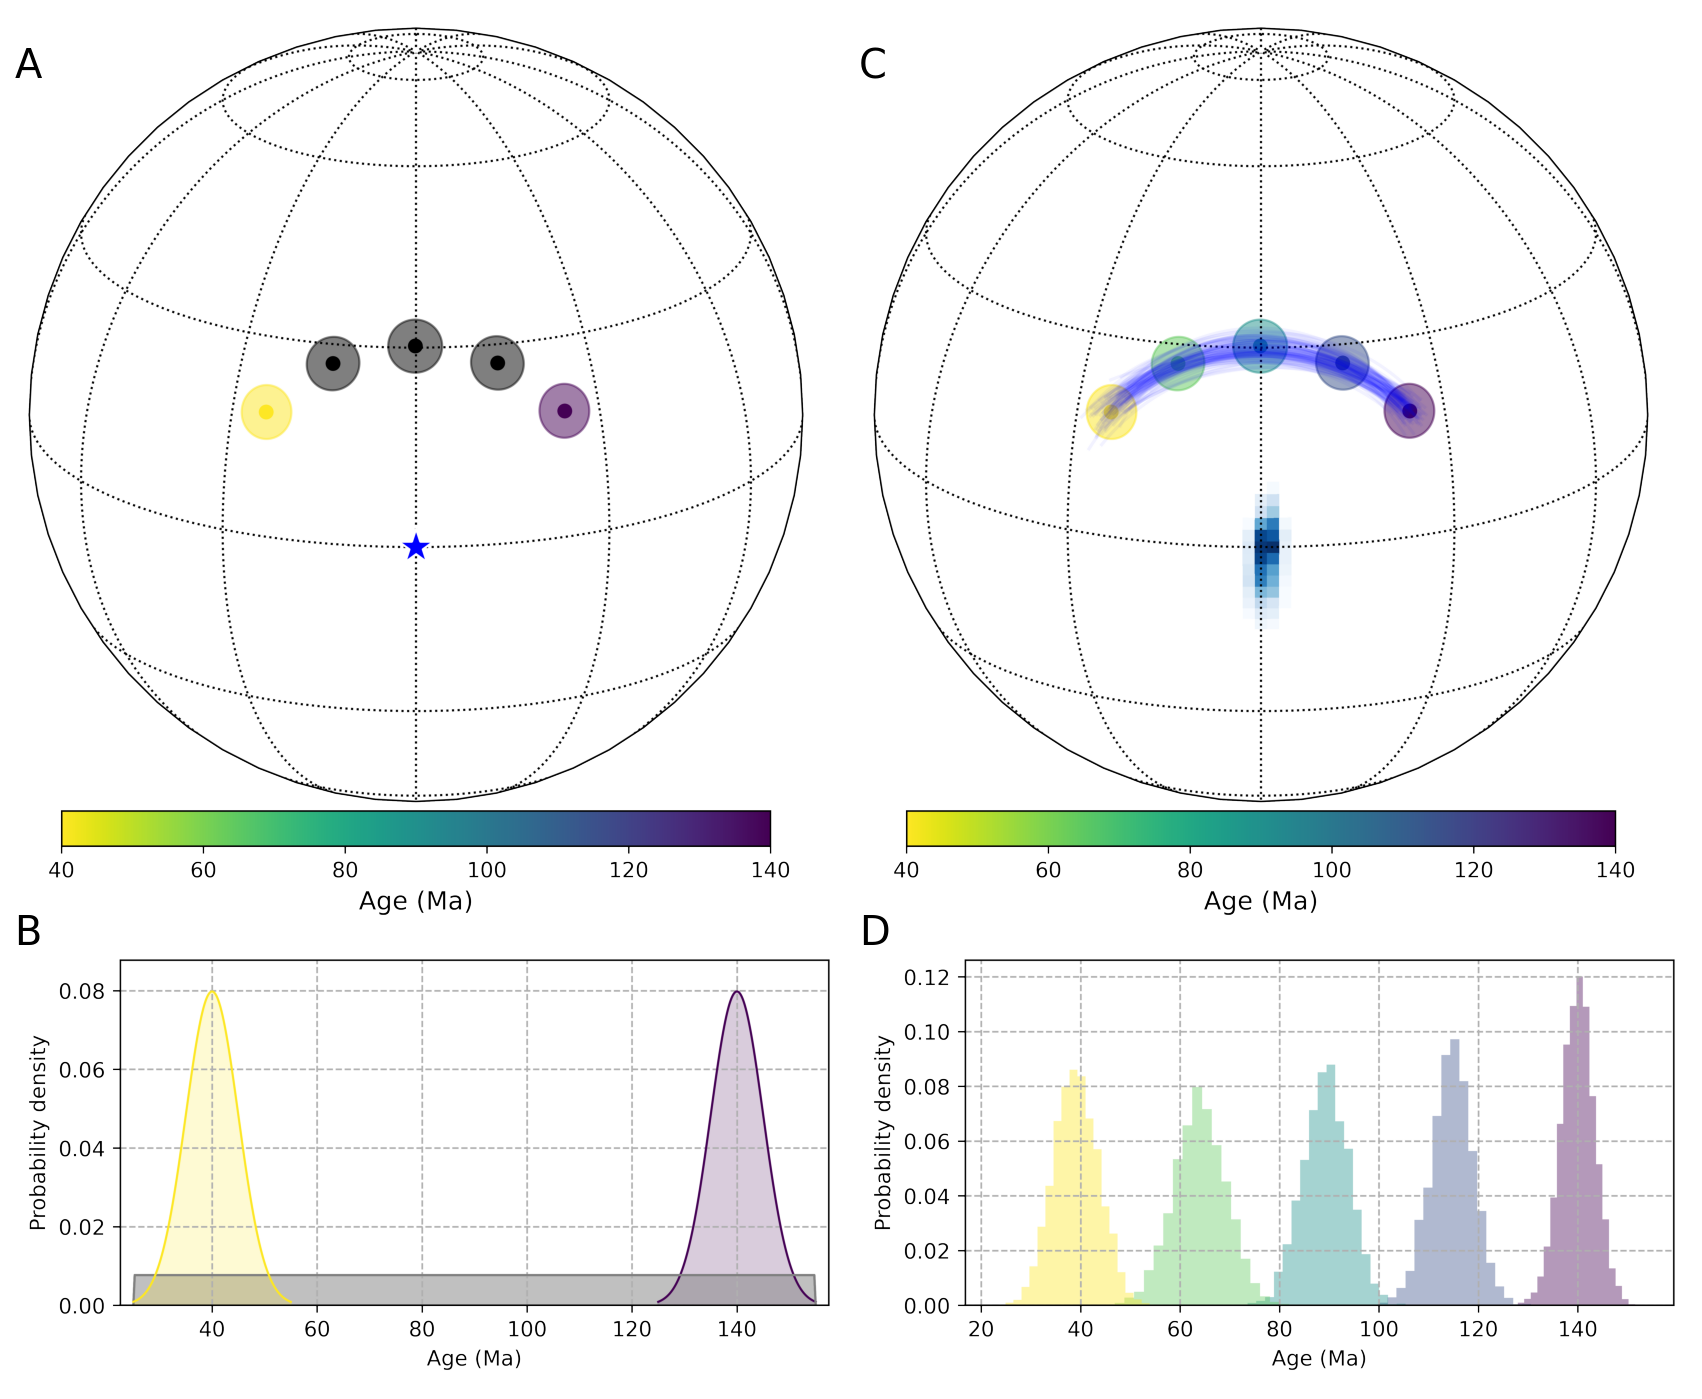

In [31]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.image as mpimg

one_euler_prior_poles_img = mpimg.imread('code_output/1_euler_prior_poles.png')
one_euler_posterior_poles_img = mpimg.imread('code_output/1_Euler_posterior_poles.png')

one_euler_prior_ages_img = mpimg.imread('code_output/1_euler_prior_ages.png')
one_euler_posterior_ages_img = mpimg.imread('code_output/1_euler_posterior_ages.png')


fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

i = 0
for ax, im in zip(grid, [one_euler_prior_poles_img,
                         one_euler_posterior_poles_img,
                         one_euler_prior_ages_img,
                         one_euler_posterior_ages_img]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.axis("off")
    
    if i == 0:
        ax.text(0,250,"A",fontsize=20)
    if i == 1:
        ax.text(0,250,"C",fontsize=20)    
    if i == 2:
        ax.text(0,0,"B",fontsize=20)
    if i == 3:
        ax.text(0,0,"D",fontsize=20)
    i = i + 1


plt.subplots_adjust(wspace=0.2, hspace=0)

plt.savefig('./code_output/fig_inversion_with_age_uncertainties.png',dpi=600,bbox_inches='tight')
plt.show()

## One Euler and tpw inversion

### generate synthetic poles

In [2]:
start_age = 100
end_age = 0
number_of_poles = 5
euler_pole = [0,0]
euler_rate = 1
pole_a95 = 4
start_pole = [24, 19]

one_euler_data = generate_APWP_poles(number_of_poles, start_pole, start_age, end_age, euler_pole, euler_rate, pole_a95)
one_euler_data

,pole_lon,pole_lat,pole_age,pole_a95
0,24.000000,19.000000,100.0,4.0
1,13.724333,27.231977,75.0,4.0
2,359.854182,30.256654,50.0,4.0
3,346.026499,27.112309,25.0,4.0
4,335.843743,18.796033,0.0,4.0


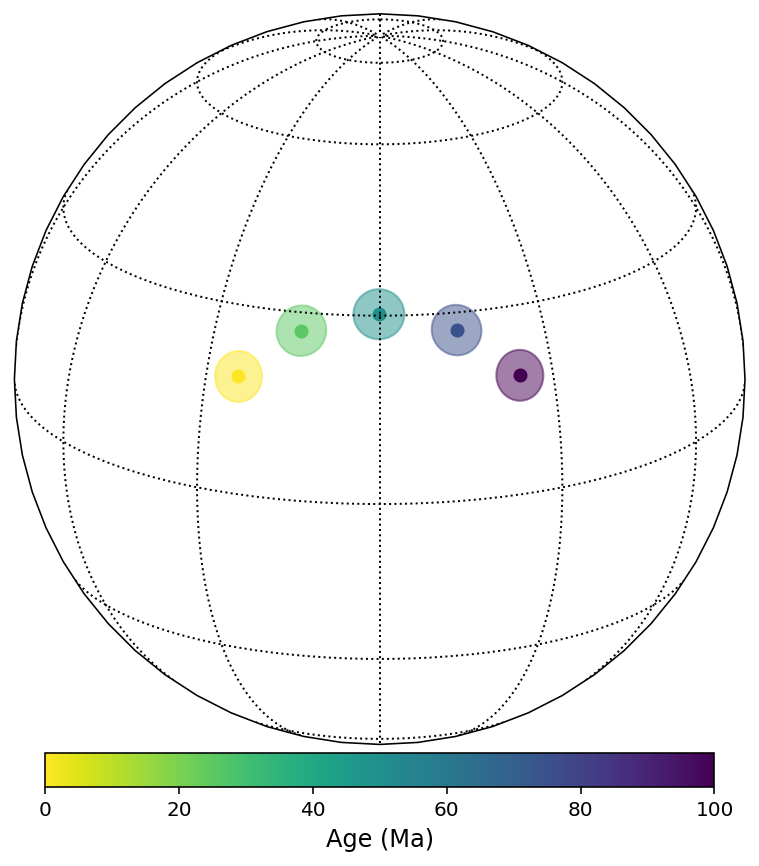

In [3]:
plot_paleomagnetic_poles(one_euler_data, central_latitude=20, add_land=0);

### invert for the Euler poles and Euler rates, tpw and tpw rates

In [4]:
with pm.Model() as model:
    
    #set the Euler pole position prior to be a uniform distribution (i.e. a Watson girdle with a very low k)
    euler_1 = Watson_Girdle('euler_1', lon_lat = [1.,1.,], k = -0.1, testval = np.array([1., 1.]), shape = 2)
    #set the Euler pole rate prior to be a uniform distribution between 0 and 4
    rate_1 = pm.Uniform('rate_1', 0, 4) 
    
    #set the the start age to be a tight normal distribution about the oldest pole age
    start_age = pm.Normal('start_pole_age', mu=one_euler_data['pole_age'].max(), sigma=0.01)
    print('starting pole age is: ', str(one_euler_data['pole_age'].max()))
    
    #set the start point of the path to be associated with the oldest paleomagnetic pole
    start_index = one_euler_data['pole_age'].argmax()
    start_lon_lat = [one_euler_data['pole_lon'].tolist()[start_index], one_euler_data['pole_lat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(one_euler_data['pole_a95'].tolist()[start_index])
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array([1., 1.]), shape = 2)
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    tpw_angle = pm.Uniform('tpw_angle', 0., 360.) 
    tpw_rate = pm.Uniform('tpw_rate', 0., 4.) 
    
    #create the Fisher distributions associated with the observed pole positions 
    for j in range(one_euler_data.shape[0]-1):
        i = j + 1
        age = pm.Normal('t'+str(i), mu=one_euler_data['pole_age'][i], sigma=0.01)
        print('pole '+str(i)+' age: ',one_euler_data['pole_age'][i])
        
        lon_lat = pole_position_1e_tpw(start, euler_1, rate_1, tpw_angle, tpw_rate, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(one_euler_data['pole_a95'].tolist()[i]), 
                            observed=[one_euler_data['pole_lon'].tolist()[i], one_euler_data['pole_lat'].tolist()[i]])
        
#     uncomment to run the model
    trace_1e_tpw = pm.sample(5000, step = pm.Metropolis(), cores=1, chains=1, init='auto')

starting pole age is:  100.0
starting pole lon/lat: [24.0, 19.0] starting pole k:  1225.0
pole 1 age:  75.0
pole 2 age:  50.0
pole 3 age:  25.0
pole 4 age:  0.0


Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [t4]
>Metropolis: [t3]
>Metropolis: [t2]
>Metropolis: [t1]
>Metropolis: [tpw_rate]
>Metropolis: [tpw_angle]
>Metropolis: [start_pole]
>Metropolis: [start_pole_age]
>Metropolis: [rate_1]
>Metropolis: [euler_1]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 151 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [5]:
pm.save_trace(trace_1e_tpw, 'code_output/1_euler_tpw_trace', overwrite=1)

'code_output/1_euler_tpw_trace'

In [6]:
trace_1e_tpw_saved = pm.load_trace('code_output/1_euler_tpw_trace',model)

In [7]:
# plt.figure(figsize=(10, 20))
# axes = pm.traceplot(trace_1e_tpw, compact=1)
# plt.subplots_adjust(hspace = 1 )
# plt.savefig('code_output/1_euler_tpw_inversion_traceplot.pdf', bbox_inches='tight')

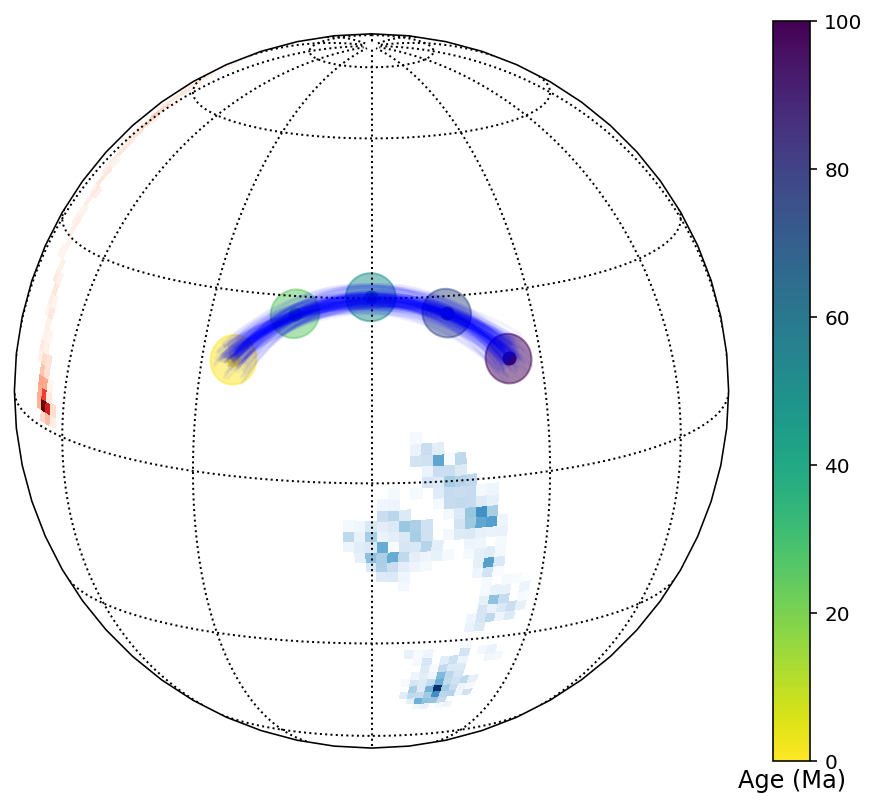

In [8]:
plot_trace_1e_tpw(trace_1e_tpw_saved, one_euler_data[['pole_lon', 'pole_lat']].to_numpy(), one_euler_data['pole_a95'], one_euler_data['pole_age'].tolist(), 
              central_lon=0, central_lat=15, num_paths_to_plot=200, savefig = 0, figname='code_output/1_Euler_tpw_inversion_.pdf')

## only tpw inversion

In [40]:
start_age = 100
end_age = 0
number_of_poles = 5
euler_pole = [0,0]
euler_rate = 1
pole_a95 = 4
start_pole = [24, 19]

one_euler_data = generate_APWP_poles(number_of_poles, start_pole, start_age, end_age, euler_pole, euler_rate, pole_a95)
one_euler_data

,pole_lon,pole_lat,pole_age,pole_a95
0,24.000000,19.000000,100.0,4.0
1,13.724333,27.231977,75.0,4.0
2,359.854182,30.256654,50.0,4.0
3,346.026499,27.112309,25.0,4.0
4,335.843743,18.796033,0.0,4.0


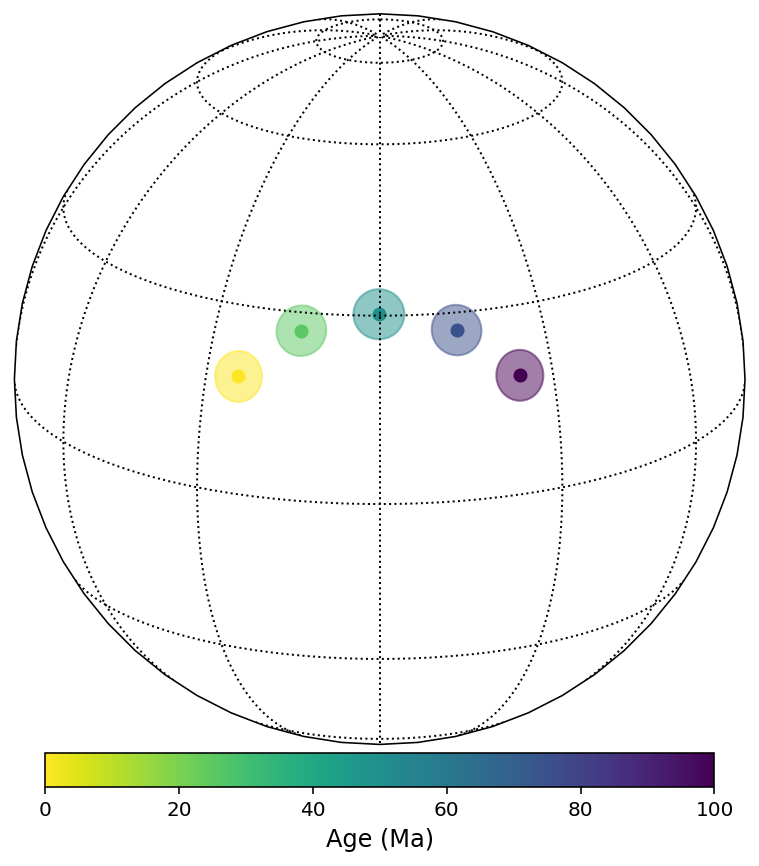

In [41]:
plot_paleomagnetic_poles(one_euler_data, central_latitude=20, add_land=0);

In [42]:
with pm.Model() as model:
    
    #set the the start age to be a tight normal distribution about the oldest pole age
    start_age = pm.Normal('start_pole_age', mu=one_euler_data['pole_age'].max(), sigma=0.01)
    print('starting pole age is: ', str(one_euler_data['pole_age'].max()))
    
    #set the start point of the path to be associated with the oldest paleomagnetic pole
    start_index = one_euler_data['pole_age'].argmax()
    start_lon_lat = [one_euler_data['pole_lon'].tolist()[start_index], one_euler_data['pole_lat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(one_euler_data['pole_a95'].tolist()[start_index])
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array([1., 1.]), shape = 2)
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    tpw_angle = pm.Uniform('tpw_angle', 0., 360.) 
    tpw_rate = pm.Uniform('tpw_rate', 0., 4.) 
    
    #create the Fisher distributions associated with the observed pole positions 
    for i in range(one_euler_data.shape[0]):
        age = pm.Normal('t'+str(i), mu=one_euler_data['pole_age'][i], sigma=0.01)
        print('pole '+str(i)+' age: ',one_euler_data['pole_age'][i])
        
        lon_lat = pole_position_tpw(start, tpw_angle, tpw_rate, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(one_euler_data['pole_a95'].tolist()[i]), 
                            observed=[one_euler_data['pole_lon'].tolist()[i], one_euler_data['pole_lat'].tolist()[i]])
        
#     uncomment to run the model
#     trace_tpw = pm.sample(1000, step = pm.Metropolis(), chains=1, init='auto')

starting pole age is:  100.0
starting pole lon/lat: [24.0, 19.0] starting pole k:  1225.0
pole 0 age:  100.0
pole 1 age:  75.0
pole 2 age:  50.0
pole 3 age:  25.0
pole 4 age:  0.0


In [43]:
# pm.save_trace(trace_tpw, 'code_output/tpw_trace', overwrite=1)

In [44]:
trace_tpw_saved = pm.load_trace('code_output/tpw_trace',model)

In [45]:
# plt.figure(figsize=(10, 20))
# axes = pm.traceplot(trace_tpw, compact=1)
# plt.subplots_adjust(hspace = 1 )
# plt.savefig('code_output/1_euler_tpw_inversion_traceplot.pdf', bbox_inches='tight')

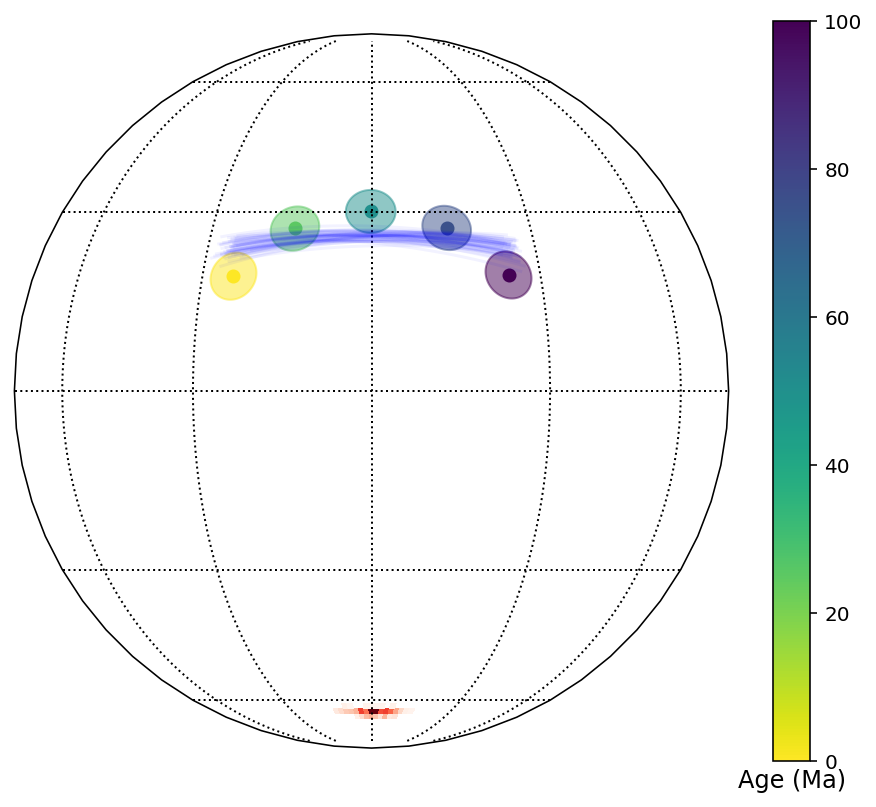

In [47]:
plot_trace_tpw(trace_tpw_saved, one_euler_data[['pole_lon', 'pole_lat']].to_numpy(), one_euler_data['pole_a95'], one_euler_data['pole_age'].tolist(), 
              central_lon=0, central_lat=0, num_paths_to_plot=50, savefig = 0, figname='code_output/tpw_inversion.pdf',)